In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import math
import seaborn as sns
import sklearn as skl
import scikitplot as skplt
import warnings
import matplotlib.pyplot as plt
import csv

In [2]:
warnings.simplefilter('ignore')

# Import dataset

In [3]:
df = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/UCMF.xls')

In [4]:
df.head()

,ID,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,...,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,1,5.0,51,19.0,11/05/06,30/03/06,0.12,GS,Normais,NaN,...,Não Calculado,Anormal,Normal,Sistólico,112,Palpitacao,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,2,3.5,50,14.0,25/05/05,19/05/05,0.02,GS,Normais,NaN,...,Não Calculado,Anormal,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,3,0.0,0,NaN,12/06/01,08/05/05,-4.05,SULA,Normais,NaN,...,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
3,4,8.1,65,19.0,15/10/09,21/04/09,0.5,NaN,Normais,NaN,...,Não Calculado,Anormal,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
4,5,39.5,142,20.0,23/01/09,24/10/99,9.6,Sulam,Normais,85.0,...,Normal,Anormal,Normal,ausente,90,NaN,NaN,M,5 - Parecer cardiológico,5 - Atividade física


In [5]:
weight_0_36 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/wtageinf.xls')
height_0_36 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/lenageinf.xls')
weight_2_20 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/wtage.xls')
height_2_20 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/statage.xls')

bmi_2_20 = pd.read_excel(r'/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/Complementary material/bmiagerev.xls')

# Remoção da columa ID

In [6]:
df = df.drop(columns='ID') #remoção da coluna ID

# Tratamento Atendimento, DN e IDADE

In [7]:
df = df[df['IDADE'].notna()] #remoção de NaN de idade
df = df[df['IDADE']!='#VALUE!'] #remoção de #VALUE de idade. Nestes casos ou a data de atendimento ou de nascença é inválida.
df['IDADE']=df['IDADE'].astype(float)
df = df[df['IDADE']>0.0] #remoção dos valores negativos de idade e maiores que 20 anos
df = df[df['IDADE']<20.0]

df = df[df['Atendimento'].notna()] #remoção de NaN de atendimento. assume-se que não foram atendidos. Não é ncessário para o problema.
df = df.drop(columns='Atendimento') #remoção da coluna atendimento

df = df[df['DN'].notna()] #remoção de NaN de data de nascimento. Não é ncessário para o problema.
df = df.drop(columns='DN') #remoção da coluna DN

df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df

,Peso,Altura,IMC,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,14.0,90,17.0,4.58,NaN,Normais,90.0,60.0,Normal,Normal,Normal,ausente,100,Assintomático,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
1,2.8,48,12.0,0.06,NORCLIN.,Normais,NaN,NaN,Não Calculado,Anormal,Normal,sistólico,110,Assintomático,NaN,M,6 - Suspeita de cardiopatia,Outro
2,65.0,0,NaN,12.62,NaN,Normais,120.0,80.0,Não Calculado,Anormal,Normal,ausente,100,Ganho de peso,NaN,F,5 - Parecer cardiológico,NaN
3,10.0,73,19.0,0.80,GS,Normais,90.0,50.0,NaN,Anormal,Normal,Sistólico,120,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
4,29.0,135,16.0,10.32,GS,NaN,NaN,NaN,Não Calculado,NaN,NaN,NaN,NaN,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15986,5.2,0,NaN,0.65,AMIL,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,100,Assintomático,NaN,M,7 - Outro,Outro
15987,0.0,0,NaN,8.05,GS,Normais,110.0,70.0,Não Calculado,Normal,Normal,ausente,92,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - HAS/dislipidemia/obesidade
15988,17.0,102,16.0,4.30,NaN,Normais,90.0,50.0,Normal,Normal,Normal,ausente,90,Palpitacao,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
15989,11.0,0,NaN,1.78,CAMED,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia


## Tratamento SEXO

In [9]:
df['SEXO'] = df['SEXO'].fillna('Indeterminado')
df['SEXO'] = df['SEXO'].replace({'Masculino':'M', 'Feminino':'F', 'masculino':'M'})
df = df[(df['SEXO']=='M') | (df['SEXO']=='F')] #remoção dos indeterminados

# Tratamento Peso, Altura e IMC

In [10]:
m_weight_0_36 = weight_0_36[(weight_0_36['Sex']==1) & (weight_0_36['Agemos']!=0.0)]
f_weight_0_36 = weight_0_36[(weight_0_36['Sex']==2) & (weight_0_36['Agemos']!=0.0)]
m_height_0_36 = height_0_36[(height_0_36['Sex']==1) & (weight_0_36['Agemos']!=0.0)]
f_height_0_36 = height_0_36[(height_0_36['Sex']==2) & (weight_0_36['Agemos']!=0.0)]

m_weight_2_20 = weight_2_20[(weight_2_20['Sex']==1) & (weight_2_20['Agemos']!=0.0)]
f_weight_2_20 = weight_2_20[(weight_2_20['Sex']==2) & (weight_2_20['Agemos']!=0.0)]
m_height_2_20 = height_2_20[(height_2_20['Sex']==1) & (weight_2_20['Agemos']!=0.0)]
f_height_2_20 = height_2_20[(height_2_20['Sex']==2) & (weight_2_20['Agemos']!=0.0)]

m_bmi_2_20 = bmi_2_20[(bmi_2_20['Sex']==1) & (bmi_2_20['Agemos']!=0.0)]
f_bmi_2_20 = bmi_2_20[(bmi_2_20['Sex']==2) & (bmi_2_20['Agemos']!=0.0)]


In [11]:
m_weight_0_36 = m_weight_0_36[m_weight_0_36['Agemos'].notna()]
f_weight_0_36 = f_weight_0_36[f_weight_0_36['Agemos'].notna()]
m_height_0_36 = m_height_0_36[m_height_0_36['Agemos'].notna()]
f_height_0_36 = f_height_0_36[f_height_0_36['Agemos'].notna()]

m_weight_2_20 = m_weight_2_20[m_weight_2_20['Agemos'].notna()]
f_weight_2_20 = f_weight_2_20[f_weight_2_20['Agemos'].notna()]
m_height_2_20 = m_height_2_20[m_height_2_20['Agemos'].notna()]
f_height_2_20 = f_height_2_20[f_height_2_20['Agemos'].notna()]


m_bmi_2_20 = m_bmi_2_20[m_bmi_2_20['Agemos'].notna()]
f_bmi_2_20 = f_bmi_2_20[f_bmi_2_20['Agemos'].notna()]


In [12]:
m_weight_0_36.loc[:,'Agemos'] = m_weight_0_36['Agemos'].astype(float)
f_weight_0_36.loc[:,'Agemos'] = f_weight_0_36['Agemos'].astype(float)
m_height_0_36.loc[:,'Agemos'] = m_height_0_36['Agemos'].astype(float)
f_height_0_36.loc[:,'Agemos'] = f_height_0_36['Agemos'].astype(float)

m_weight_2_20.loc[:,'Agemos'] = m_weight_2_20['Agemos'].astype(float)
f_weight_2_20.loc[:,'Agemos'] = f_weight_2_20['Agemos'].astype(float)
m_height_2_20.loc[:,'Agemos'] = m_height_2_20['Agemos'].astype(float)
f_height_2_20.loc[:,'Agemos'] = f_height_2_20['Agemos'].astype(float)

m_bmi_2_20.loc[:,'Agemos'] = m_bmi_2_20['Agemos'].astype(float)
f_bmi_2_20.loc[:,'Agemos'] = f_bmi_2_20['Agemos'].astype(float)

m_weight_0_36.loc[:,'P50'] = m_weight_0_36['P50'].astype(float)
f_weight_0_36.loc[:,'P50'] = f_weight_0_36['P50'].astype(float)
m_height_0_36.loc[:,'P50'] = m_height_0_36['P50'].astype(float)
f_height_0_36.loc[:,'P50'] = f_height_0_36['P50'].astype(float)

m_weight_2_20.loc[:,'P50'] = m_weight_2_20['P50'].astype(float)
f_weight_2_20.loc[:,'P50'] = f_weight_2_20['P50'].astype(float)
m_height_2_20.loc[:,'P50'] = m_height_2_20['P50'].astype(float)
f_height_2_20.loc[:,'P50'] = f_height_2_20['P50'].astype(float)

m_bmi_2_20.loc[:,'P50'] = m_bmi_2_20['P50'].astype(float)
f_bmi_2_20.loc[:,'P50'] = f_bmi_2_20['P50'].astype(float)

In [13]:
m_weight_0_36.loc[:,'Agemos'] = m_weight_0_36['Agemos'].div(12.0)
f_weight_0_36.loc[:,'Agemos'] = f_weight_0_36['Agemos'].div(12.0)
m_height_0_36.loc[:,'Agemos'] = m_height_0_36['Agemos'].div(12.0)
f_height_0_36.loc[:,'Agemos'] = f_height_0_36['Agemos'].div(12.0)

m_weight_2_20.loc[:,'Agemos'] = m_weight_2_20['Agemos'].div(12.0)
f_weight_2_20.loc[:,'Agemos'] = f_weight_2_20['Agemos'].div(12.0)
m_height_2_20.loc[:,'Agemos'] = m_height_2_20['Agemos'].div(12.0)
f_height_2_20.loc[:,'Agemos'] = f_height_2_20['Agemos'].div(12.0)

m_bmi_2_20.loc[:,'Agemos'] = m_bmi_2_20['Agemos'].div(12.0)
f_bmi_2_20.loc[:,'Agemos'] = f_bmi_2_20['Agemos'].div(12.0)


<AxesSubplot:xlabel='Agemos'>

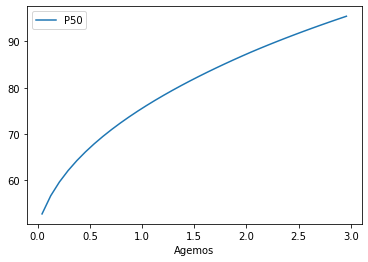

In [14]:
m_height_0_36.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

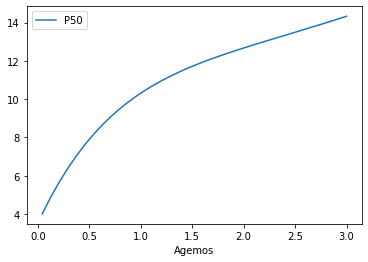

In [15]:
m_weight_0_36.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

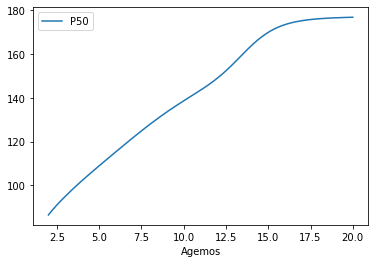

In [16]:
m_height_2_20.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

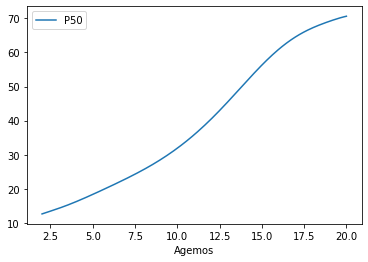

In [17]:
m_weight_2_20.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

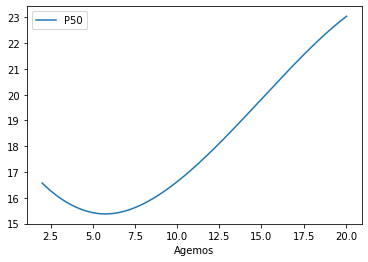

In [18]:
m_bmi_2_20.plot(x='Agemos', y='P50')

<AxesSubplot:xlabel='Agemos'>

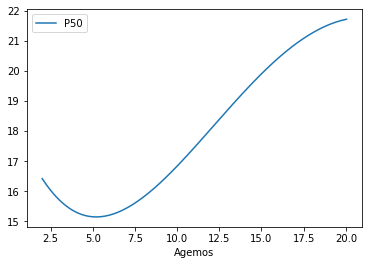

In [19]:
f_bmi_2_20.plot(x='Agemos', y='P50')

In [20]:
f_peso_idade1_curva = np.polyfit(f_weight_0_36['Agemos'], f_weight_0_36['P50'],2)
f_altr_idade1_curva = np.polyfit(f_height_0_36['Agemos'], f_height_0_36['P50'],2)
m_peso_idade1_curva = np.polyfit(m_weight_0_36['Agemos'], m_weight_0_36['P50'],2)
m_altr_idade1_curva = np.polyfit(m_height_0_36['Agemos'], m_height_0_36['P50'],2)

f_peso_idade2_curva = np.polyfit(f_weight_2_20['Agemos'], f_weight_2_20['P50'],2)
f_altr_idade2_curva = np.polyfit(f_height_2_20['Agemos'], f_height_2_20['P50'],2)
m_peso_idade2_curva = np.polyfit(m_weight_2_20['Agemos'], m_weight_2_20['P50'],2)
m_altr_idade2_curva = np.polyfit(m_height_2_20['Agemos'], m_height_2_20['P50'],2)

m_bmi_2_20_curva = np.polyfit(m_bmi_2_20['Agemos'], m_bmi_2_20['P50'], 3)
f_bmi_2_20_curva = np.polyfit(f_bmi_2_20['Agemos'], f_bmi_2_20['P50'], 3)


In [21]:
predict_f_peso_idade1 = np.poly1d(f_peso_idade1_curva)
predict_f_altr_idade1 = np.poly1d(f_altr_idade1_curva)
predict_m_peso_idade1 = np.poly1d(m_peso_idade1_curva)
predict_m_altr_idade1 = np.poly1d(m_altr_idade1_curva)

predict_f_peso_idade2 = np.poly1d(f_peso_idade2_curva)
predict_f_altr_idade2 = np.poly1d(f_altr_idade2_curva)
predict_m_peso_idade2 = np.poly1d(m_peso_idade2_curva)
predict_m_altr_idade2 = np.poly1d(m_altr_idade2_curva)

predict_m_bmi_2_20 = np.poly1d(m_bmi_2_20_curva)
predict_f_bmi_2_20 = np.poly1d(f_bmi_2_20_curva)


In [22]:
df1 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_peso_idade1(df1)

df2 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_peso_idade1(df2)

df3 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_peso_idade2(df3)

df4 = df['IDADE'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Peso'][(df.loc[:,'Peso']<=0.0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_peso_idade2(df4)

#########################################################################################################################

df5 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_altr_idade1(df5)

df6 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] < 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_altr_idade1(df6)

df7 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'F')] = predict_f_altr_idade2(df7)

df8 = df['IDADE'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')]
df['Altura'][(df.loc[:,'Altura']<=0) & (df.loc[:,'IDADE'] >= 3.0) & (df.loc[:,'SEXO'] == 'M')] = predict_m_altr_idade2(df8)

In [23]:
df.shape[0]

15587

In [24]:
def outls_w(data_m, data_f, min_age, max_age, tol):

    data_m['Agemos'] = round(data_m['Agemos'], 4)
    data_f['Agemos'] = round(data_f['Agemos'], 4)
    df.reset_index(drop=True, inplace=True)

    count = 0
    rows_to_drop = []
    for q in range(df.shape[0]):
            if((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'M')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Peso'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Peso'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    
            elif((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'F')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Peso'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Peso'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
    print (count)
    print('ok')
    return rows_to_drop
    
    

In [25]:
def outls_h(data_m, data_f, min_age, max_age, tol):
    data_f['Agemos'] = round(data_f['Agemos'], 4)
    df.reset_index(drop=True, inplace=True)

    count = 0
    rows_to_drop = []
    for q in range(df.shape[0]):
            if((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'M')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Altura'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Altura'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    
            elif((df['IDADE'].iloc[q] >= min_age) & (df['IDADE'].iloc[q] < max_age) & (df['SEXO'].iloc[q] == 'F')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p97  = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P97']), 3)
                p3   = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['Altura'].iloc[q]) > (p97 *(1+tol/100))):
                    rows_to_drop.append (q)
                    count += 1
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )

                elif((df['Altura'].iloc[q]) < (p3 *(1-tol/100))):
                    rows_to_drop.append (q)
                    count += 1
    print (count)
    print('ok')
    return rows_to_drop

In [26]:
rows = outls_w(m_weight_0_36, f_weight_0_36, 0, 3, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

253
ok


In [27]:
rows = outls_h(m_height_0_36, f_height_0_36, 0, 3, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

16
ok


In [28]:
rows = outls_w(m_weight_2_20, f_weight_2_20, 3, 20, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

359
ok


In [29]:
rows = outls_h(m_height_2_20, f_height_2_20, 3, 20, 20)
df = df.drop(rows)
df = df.sample(frac=1).reset_index(drop=True)

20
ok


In [30]:
df.shape[0]

14939

In [31]:
df

,Peso,Altura,IMC,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,25.0,112,20.0,8.29,same,Normais,90.0,60.0,Normal,Anormal,Normal,sistólico,100,Dor precordial,Palpitacao,F,6 - Suspeita de cardiopatia,6 - Dor precordial
1,18.0,125,NaN,7.53,GS,Normais,90.0,60.0,Não Calculado,Normal,Normal,ausente,100,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
2,14.5,96,16.0,3.07,Unimed Rec,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,111,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - Dor precordial
3,13.0,100,13.0,5.26,GS,Normais,90.0,50.0,Normal,Anormal,Normal,Sistólico,100,Assintomático,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
4,12.0,84,17.0,1.63,GS,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,88,NaN,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14934,9.6,67,21.0,0.81,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro
14935,22.0,121,15.0,6.67,SB,Normais,100.0,60.0,Normal,Normal,Normal,ausente,88,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Dor precordial
14936,47.0,144,23.0,9.16,GRUPO,Normais,120.0,80.0,HAS-1 PAS,Anormal,Normal,Sistólico,70,Ganho de peso,NaN,F,5 - Parecer cardiológico,NaN
14937,18.0,104,17.0,4.19,SA,Normais,100.0,60.0,Normal,Normal,Normal,sistólico,88,NaN,NaN,F,7 - Outro,Outro


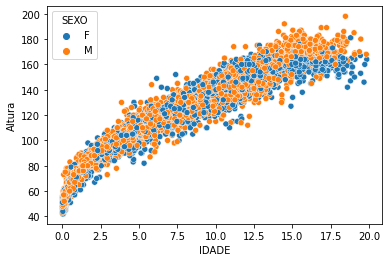

In [32]:
sns.scatterplot(x="IDADE", y="Altura",
              hue="SEXO",
              data=df);

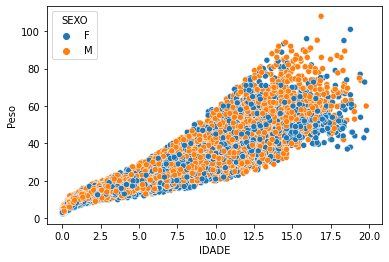

In [33]:
sns.scatterplot(x="IDADE", y="Peso",
              hue="SEXO",
              data=df);

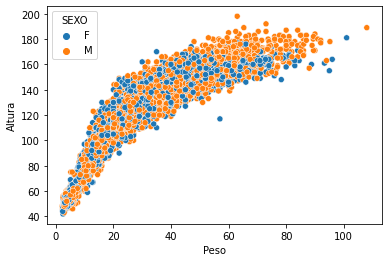

In [34]:
sns.scatterplot(x="Peso", y="Altura",
              hue="SEXO",
              data=df);

In [35]:
df.loc[:,'IMC'] = df['Peso']/((df['Altura']/100)**2)

In [36]:
df = df[df['IMC']<50]

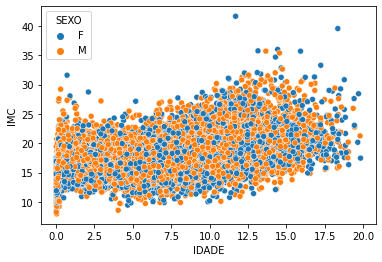

In [37]:
sns.scatterplot(x="IDADE", y="IMC",
              hue="SEXO",
              data=df);

# Tratamento Convenio

In [38]:
df = df.drop(columns='Convenio') #Não é necessário ao problema

# Tratamento Pulsos

In [39]:
df = df.drop(columns='PULSOS') #Não é necessário ao problema

# Tratamento NORMAL x ANORMAL

In [40]:
df['NORMAL X ANORMAL'] = df['NORMAL X ANORMAL'].str.replace('anormal','Anormal')
df['NORMAL X ANORMAL'] = df['NORMAL X ANORMAL'].str.replace('Normais','Normal')

# Tratamento SOPRO

In [41]:
df['NORMAL X ANORMAL'] = df['NORMAL X ANORMAL'].str.replace('anormal','Anormal')
df['NORMAL X ANORMAL'] = df['NORMAL X ANORMAL'].str.replace('Normais','Normal')

## Transformação das variáveis diferentes de "ausente"

In [42]:
df['SOPRO'].value_counts()

ausente                   9319
Sistólico                 3993
sistólico                  938
contínuo                    22
Contínuo                    15
diastólico                   9
Sistolico e diastólico       3
Name: SOPRO, dtype: int64

Do ponto de vista do exercício, para apurar se existe patologia cardíaca ou não, só interessa a presença ou não do sopro. Concluíndo, podemos reduzir a variável SOPRO a uma variável binária: {ausente, presente}.

In [43]:
df['SOPRO'] = df['SOPRO'].replace({'sistólico':'Sistólico', 'contínuo':'Contínuo'})

In [44]:
df['SOPRO'] = df['SOPRO'].replace({'Sistólico':'presente', 'Contínuo':'presente', 'diastólico':'presente', 'Sistolico e diastólico':'presente'})

In [45]:
df['SOPRO'].value_counts()

ausente     9319
presente    4980
Name: SOPRO, dtype: int64

# Tratamento FC

In [46]:
def testKNN_r(df_prev, df_obj, std):
    x = df_prev
    y = df_obj
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    from sklearn.preprocessing import normalize
    
    if std == 1:
        x = sc.fit_transform(x)
    else:
        x = normalize(x)
    
    errors = []
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size = 0.25, random_state = 0)
    k_ok = 0
    
    gain = 0
    regressor = KNeighborsRegressor(n_neighbors = 1)
    regressor.fit(X_train,Y_train)
    error_0 = round(mean_absolute_error(Y_test,regressor.predict(X_test)),3)
    
    for k in range (1,20,2):
        regressor = KNeighborsRegressor(n_neighbors = k)
        regressor.fit(X_train,Y_train)
        error = round(mean_absolute_error(Y_test,regressor.predict(X_test)),3)
        gain = round(error_0 - error,3)
        error_0 = error
        errors.append({'K':k, 'mae':error, 'gain':gain})
    
    print(errors)

In [47]:
#df['FC'] = df['FC'].astype('str')
df.FC.unique()

array([100, 111, 88, 80, 96, 108, nan, 90, 84, 102, 130, 112, 125, 70,
       110, 76, 72, 92, 60, 78, 85, 82, 120, 140, 65, 98, 150, 52, 132,
       68, 62, 64, 86, 122, 136, 160, 115, 104, 75, 128, 89, 94, 300, 124,
       95, 74, 66, 50, 129, 144, 135, 56, 123, 10, 106, 55, 142, 148, 79,
       146, 134, 900, 180, 118, 87, 116, 154, 188, 114, 170, '140-160',
       69, 182, 164, 200, 145, 156, 93, '65-100', 109, 57, 12, 99, 137,
       8096, 152, '60-100', 91, 214, '120-180', 981, '66-80', 780, 133,
       '140-200', 126, 194, '156 a 168', 138, 43, '50-100', '140-150',
       801, 81, 83, 230, 105, '170-150', 73, '92-100', 16, '140-120',
       '200-300', 48, 972, 192, 107, 9288, 1120, 97, 165, 1560],
      dtype=object)

In [48]:
import re
for i in range(df.shape[0]):
    if type(df['FC'].iloc[i]) == str:
        v = re.findall(r'\d+', df['FC'].iloc[i]) #retorna um vector com os valores númericos encontrados. Ex: 120-140 --> 120;140
        v = [int(k) for k in v]
        df['FC'].iloc[i] = int(abs(v[1]-v[0])/2) #calcula o valor intermédio entre os dois valores e guarda

df = df.sample(frac=1).reset_index(drop=True)

In [49]:
df2 = df
df2 = df2[df2['FC'].notna()]
df2 = df2.sample(frac=1).reset_index(drop=True)
df2['FC'] = df2['FC'].astype(int)
df2

,Peso,Altura,IMC,IDADE,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,18.500000,110,15.289256,4.86,100.0,65.0,Normal,Normal,Normal,ausente,90,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
1,25.800000,132,14.807163,8.82,100.0,50.0,Normal,Anormal,Normal,presente,90,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
2,12.748415,88,16.462312,2.23,NaN,NaN,Não Calculado,Normal,Normal,ausente,100,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
3,32.000000,143,15.648687,10.53,100.0,60.0,Não Calculado,Normal,Normal,ausente,78,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
4,48.500000,147,22.444352,13.67,100.0,60.0,Normal,Normal,Normal,ausente,96,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13616,43.000000,154,18.131219,12.67,110.0,70.0,Não Calculado,Normal,Normal,ausente,80,Dor precordial,Dispneia,M,6 - Suspeita de cardiopatia,6 - Dor precordial
13617,54.000000,164,20.077335,13.43,110.0,80.0,Normal,Normal,Normal,ausente,90,NaN,NaN,F,2 - Check-up,NaN
13618,18.560777,109,15.622234,5.09,100.0,60.0,Não Calculado,Anormal,Normal,presente,100,Assintomático,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
13619,18.951265,109,15.950901,5.10,110.0,70.0,Não Calculado,Normal,Normal,ausente,80,Dispneia,NaN,F,2 - Check-up,NaN


<AxesSubplot:>

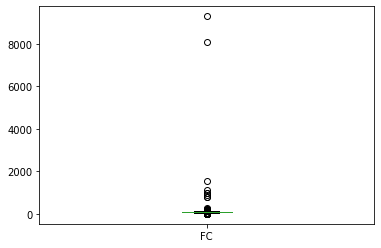

In [50]:
df['FC'].plot.box()

In [51]:
#Q1 = df1['FC'].quantile(q=0.25)
#Q3 = df1['FC'].quantile(q=0.75)
#IQR = Q3 - Q1
#limit_min = Q1 - 1.5 * IQR
#limit_max = Q3 + 1.5 * IQR

In [52]:
#df1 = df1[df1['FC'] > limit_min]
#df1 = df1[df1['FC'] < limit_max]
#df1['FC'].plot.box()

In [53]:
df = df[df['FC'] <= 230] #Valor máximo de frequência cardíaca
df = df.sample(frac=1).reset_index(drop=True)

In [54]:
df2 = df2[df2['FC'] <= 230]
df2 = df2.sample(frac=1).reset_index(drop=True)

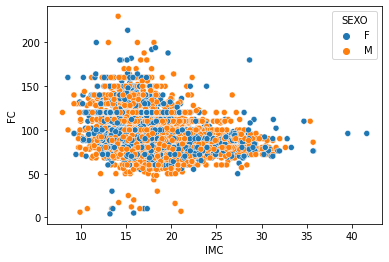

In [55]:
sns.scatterplot(x="IMC", y="FC",
              hue="SEXO",
              data=df);

In [56]:
X = df2[['IMC','IDADE']]
Y = df2['FC']

In [57]:
testKNN_r(X,Y,1)

[{'K': 1, 'mae': 12.068, 'gain': 0.0}, {'K': 3, 'mae': 10.419, 'gain': 1.649}, {'K': 5, 'mae': 9.857, 'gain': 0.562}, {'K': 7, 'mae': 9.621, 'gain': 0.236}, {'K': 9, 'mae': 9.491, 'gain': 0.13}, {'K': 11, 'mae': 9.335, 'gain': 0.156}, {'K': 13, 'mae': 9.264, 'gain': 0.071}, {'K': 15, 'mae': 9.227, 'gain': 0.037}, {'K': 17, 'mae': 9.199, 'gain': 0.028}, {'K': 19, 'mae': 9.174, 'gain': 0.025}]


In [58]:
testKNN_r(X,Y,0)

[{'K': 1, 'mae': 12.939, 'gain': 0.0}, {'K': 3, 'mae': 10.7, 'gain': 2.239}, {'K': 5, 'mae': 10.165, 'gain': 0.535}, {'K': 7, 'mae': 9.885, 'gain': 0.28}, {'K': 9, 'mae': 9.633, 'gain': 0.252}, {'K': 11, 'mae': 9.491, 'gain': 0.142}, {'K': 13, 'mae': 9.405, 'gain': 0.086}, {'K': 15, 'mae': 9.331, 'gain': 0.074}, {'K': 17, 'mae': 9.288, 'gain': 0.043}, {'K': 19, 'mae': 9.294, 'gain': -0.006}]


In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 0)

In [60]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors = 9)
regressor.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=9)

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [63]:
mse = mean_squared_error(Y_test, regressor.predict(X_test))
mae = mean_absolute_error(Y_test, regressor.predict(X_test))

In [64]:
print(mse, mae)

161.86760048323376 9.493029026675808


In [65]:
for k in range(df.shape[0]): #em todo as linhas
    if pd.isnull(df['FC'].iloc[k]):   #caso um valor de FC seja NaN
        Q = df[['IMC','IDADE']].iloc[k]
        df['FC'].iloc[k] = regressor.predict(Q)

In [66]:
df = df[df['FC'] >= 40]  #Valor mínimo de frequência cardiaca

<AxesSubplot:>

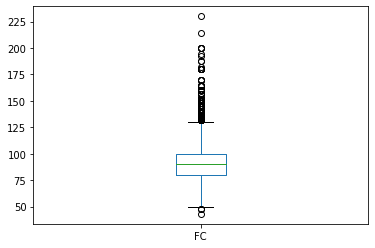

In [67]:
df['FC'].plot.box()

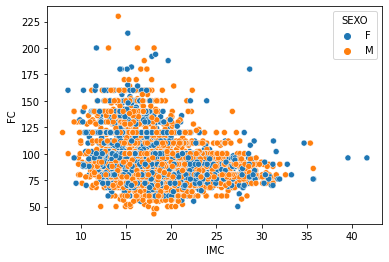

In [68]:
sns.scatterplot(x="IMC", y="FC",
              hue="SEXO",
              data=df);

## Tratamento HDA 1

In [69]:
df['HDA 1'] = df['HDA 1'].fillna('Sem histórico')

In [70]:
df['HDA 1'].value_counts()

Assintomático      7873
Sem histórico      3079
Dor precordial      748
Dispneia            621
Palpitacao          504
Desmaio/tontura     240
Cianose             236
Outro               177
Ganho de peso       116
Name: HDA 1, dtype: int64

In [71]:
df['HDA 1'].unique()

array(['Assintomático', 'Sem histórico', 'Palpitacao', 'Dor precordial',
       'Dispneia', 'Desmaio/tontura', 'Outro', 'Cianose', 'Ganho de peso'],
      dtype=object)

## Tratamento HDA2

In [72]:
df['HDA2'] = df['HDA2'].fillna('Sem histórico')

In [73]:
df['HDA2'].value_counts()

Sem histórico      13055
Palpitacao           134
Dispneia             110
Dor precordial        86
Cianose               65
Desmaio/tontura       61
Outro                 56
Ganho de peso         26
Assintomático          1
Name: HDA2, dtype: int64

In [74]:
df['HDA2'].unique()

array(['Sem histórico', 'Palpitacao', 'Dor precordial', 'Dispneia',
       'Cianose', 'Ganho de peso', 'Desmaio/tontura', 'Assintomático',
       'Outro'], dtype=object)

In [75]:
df[df['PA SISTOLICA']<500]
df = df.sample(frac=1).reset_index(drop=True)

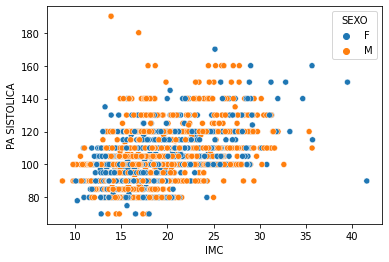

In [76]:
sns.scatterplot(x="IMC", y="PA SISTOLICA",
              hue="SEXO",
              data=df[(df['PA SISTOLICA']<500) & (df['PA SISTOLICA']>60)]);

## PA_SISTÓLICA e PA_DIASTÓLICA

In [77]:
df3 = df
df3 = df3[(df3['PA SISTOLICA']<500) & (df3['PA SISTOLICA']>60) & (df3['PA DIASTOLICA']>20)]
df3 = df3[(df3['PA SISTOLICA'].notna()) & (df3['PA DIASTOLICA'].notna())]
df3 = df3.sample(frac=1).reset_index(drop=True)

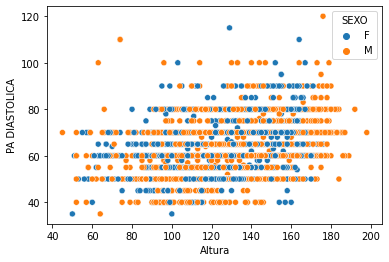

In [78]:
sns.scatterplot(x="Altura", y="PA DIASTOLICA",
              hue="SEXO",
              data=df3);

In [79]:
Z = df3[['Peso','Altura','IDADE']]
W = df3[['PA SISTOLICA']]

In [80]:
testKNN_r(Z,W,1)

[{'K': 1, 'mae': 8.933, 'gain': 0.0}, {'K': 3, 'mae': 7.808, 'gain': 1.125}, {'K': 5, 'mae': 7.409, 'gain': 0.399}, {'K': 7, 'mae': 7.202, 'gain': 0.207}, {'K': 9, 'mae': 7.081, 'gain': 0.121}, {'K': 11, 'mae': 7.035, 'gain': 0.046}, {'K': 13, 'mae': 6.994, 'gain': 0.041}, {'K': 15, 'mae': 6.948, 'gain': 0.046}, {'K': 17, 'mae': 6.917, 'gain': 0.031}, {'K': 19, 'mae': 6.908, 'gain': 0.009}]


In [81]:
testKNN_r(Z,W,0)

[{'K': 1, 'mae': 8.997, 'gain': 0.0}, {'K': 3, 'mae': 7.907, 'gain': 1.09}, {'K': 5, 'mae': 7.541, 'gain': 0.366}, {'K': 7, 'mae': 7.282, 'gain': 0.259}, {'K': 9, 'mae': 7.165, 'gain': 0.117}, {'K': 11, 'mae': 7.087, 'gain': 0.078}, {'K': 13, 'mae': 6.999, 'gain': 0.088}, {'K': 15, 'mae': 6.964, 'gain': 0.035}, {'K': 17, 'mae': 6.932, 'gain': 0.032}, {'K': 19, 'mae': 6.905, 'gain': 0.027}]


In [82]:
from sklearn.model_selection import train_test_split
Z_train, Z_test, W_train, W_test = train_test_split(Z,W,test_size = 0.25, random_state = 0)

In [83]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Z_train = sc.fit_transform(Z_train)
Z_test = sc.transform(Z_test)

In [84]:
from sklearn.neighbors import KNeighborsRegressor
regressor2 = KNeighborsRegressor(n_neighbors = 7)
regressor2.fit(Z_train, W_train)

KNeighborsRegressor(n_neighbors=7)

In [85]:
mse2 = mean_squared_error(W_test, regressor2.predict(Z_test))
mae2 = mean_absolute_error(W_test, regressor2.predict(Z_test))

In [86]:
print(mse2, mae2)

91.54640780036863 7.1993448759943846


In [87]:
E = df3[['Peso','Altura','IDADE']]
R = df3[['PA DIASTOLICA']]

In [88]:
testKNN_r(E,R,1)

[{'K': 1, 'mae': 7.643, 'gain': 0.0}, {'K': 3, 'mae': 6.746, 'gain': 0.897}, {'K': 5, 'mae': 6.388, 'gain': 0.358}, {'K': 7, 'mae': 6.219, 'gain': 0.169}, {'K': 9, 'mae': 6.101, 'gain': 0.118}, {'K': 11, 'mae': 6.066, 'gain': 0.035}, {'K': 13, 'mae': 5.978, 'gain': 0.088}, {'K': 15, 'mae': 5.908, 'gain': 0.07}, {'K': 17, 'mae': 5.89, 'gain': 0.018}, {'K': 19, 'mae': 5.85, 'gain': 0.04}]


In [89]:
testKNN_r(E,R,0)

[{'K': 1, 'mae': 7.645, 'gain': 0.0}, {'K': 3, 'mae': 6.783, 'gain': 0.862}, {'K': 5, 'mae': 6.426, 'gain': 0.357}, {'K': 7, 'mae': 6.207, 'gain': 0.219}, {'K': 9, 'mae': 6.099, 'gain': 0.108}, {'K': 11, 'mae': 6.055, 'gain': 0.044}, {'K': 13, 'mae': 5.981, 'gain': 0.074}, {'K': 15, 'mae': 5.941, 'gain': 0.04}, {'K': 17, 'mae': 5.92, 'gain': 0.021}, {'K': 19, 'mae': 5.91, 'gain': 0.01}]


In [90]:
E_train, E_test, R_train, R_test = train_test_split(E,R,test_size = 0.25, random_state = 0)

In [91]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
E_train = sc.fit_transform(E_train)
E_test = sc.transform(E_test)

In [92]:
from sklearn.neighbors import KNeighborsRegressor
regressor3 = KNeighborsRegressor(n_neighbors = 7)
regressor3.fit(E_train, R_train)

KNeighborsRegressor(n_neighbors=7)

In [93]:
mse3 = mean_squared_error(R_test, regressor3.predict(E_test))
mae3 = mean_absolute_error(R_test, regressor3.predict(E_test))

In [94]:
print(mse3, mae3)

69.61765014850113 6.222675312520892


In [95]:
for o in range(df.shape[0]): #em todo as linhas
    if pd.isnull((df['PA SISTOLICA'].iloc[o])):
        K = df[['Peso','Altura','IDADE']].iloc[o].values.reshape(1,-1)
        #K = K.values.reshape(1,-1)
        df['PA SISTOLICA'].iloc[o] = regressor2.predict(K)
    
    if pd.isnull((df['PA DIASTOLICA'].iloc[o])):
        Q = df[['Peso','Altura','IDADE']].iloc[o].values.reshape(1,-1)
        #Q = Q.values.reshape(1,-1)
        df['PA DIASTOLICA'].iloc[o] = regressor3.predict(Q)
        

In [96]:
df = df[(df['PA SISTOLICA']<200) & (df['PA SISTOLICA']>60) & (df['PA DIASTOLICA']>20)]

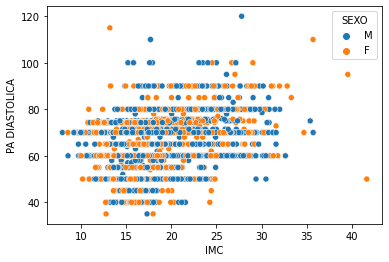

In [97]:
sns.scatterplot(x="IMC", y="PA DIASTOLICA",
              hue="SEXO",
              data=df);

<AxesSubplot:>

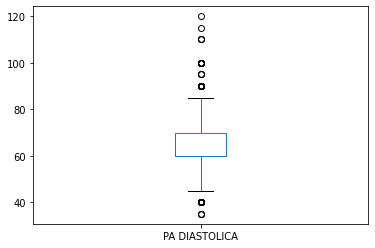

In [98]:
df['PA DIASTOLICA'].plot.box()

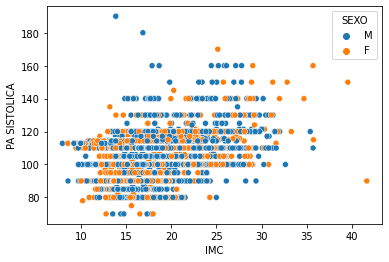

In [99]:
sns.scatterplot(x="IMC", y="PA SISTOLICA",
              hue="SEXO",
              data=df);

<AxesSubplot:>

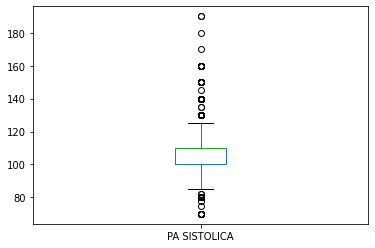

In [100]:
df['PA SISTOLICA'].plot.box()

In [101]:
df.shape[0]

13588

In [102]:
df = df[(df['B2'].notna()) & (df['NORMAL X ANORMAL'].notna())]

In [103]:
df = df.drop(columns='PPA') 

In [104]:
df['HDA 1'].value_counts()

Assintomático      7852
Sem histórico      3079
Dor precordial      748
Dispneia            620
Palpitacao          503
Desmaio/tontura     239
Cianose             234
Outro               177
Ganho de peso       116
Name: HDA 1, dtype: int64

In [105]:
df.isna().sum()

Peso                   0
Altura                 0
IMC                    0
IDADE                  0
PA SISTOLICA           0
PA DIASTOLICA          0
NORMAL X ANORMAL       0
B2                     0
SOPRO                  0
FC                     0
HDA 1                  0
HDA2                   0
SEXO                   0
MOTIVO1              120
MOTIVO2             3175
dtype: int64

In [106]:
dfx = df[df['HDA 1']== "Ganho de peso"]

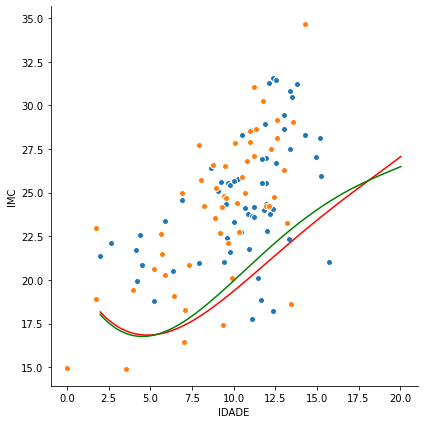

In [107]:
X_plot = m_bmi_2_20['Agemos']
Y_plot = m_bmi_2_20['P85']
X2_plot = f_bmi_2_20['Agemos']
Y2_plot = f_bmi_2_20['P85']
g = sns.FacetGrid(dfx, size = 6, hue = "SEXO")
g = g.map(plt.scatter, "IDADE", "IMC", edgecolor="w")
#m_bmi_2_20.plot(x='Agemos', y='P50')
plt.plot(X_plot, Y_plot, color='r')
plt.plot(X2_plot, Y2_plot, color='g')
plt.show()

In [108]:
df['HDA 1'][(df['MOTIVO2']=='6 - Dor precordial') & (df['HDA 1']=='Sem histórico')]='Dor precordial'

In [109]:
df['HDA 1'][(df['MOTIVO2']=='6 - Cianose') & (df['HDA 1']== 'Sem histórico')] = 'Cianose'

In [110]:
df.loc[(((df['HDA 1'].isna())) & (df['MOTIVO2']=='6 - Cianose e dispnéia')), 'HDA 1'] = "Cianose"
df.loc[(((df['HDA2'].isna())) & (df['MOTIVO2']=='6 - Cianose e dispnéia')), 'HDA2'] = "Dispneia"

In [111]:
def over_imc(data_m, data_f):
    data_f['Agemos'] = round(data_f['Agemos'], 4)
    df.reset_index(drop=True, inplace=True)

   
    for q in range(df.shape[0]):
            if((df['SEXO'].iloc[q] == 'M') & (df['HDA 1'].iloc[q] == 'Sem histórico')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p85  = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P85']), 3)
                #p3   = round (float (data_m.loc[(data_m['Agemos']==(min(data_m['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['IMC'].iloc[q]) > p85):
                    df['HDA 1'].iloc[q] = 'Ganho de peso'
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )
                    #print('M added')
                                    
            elif((df['SEXO'].iloc[q] == 'F') & (df['HDA 1'].iloc[q] == 'Sem histórico')):
                # encontrar o p97 do valor mais proximo da idade na tabela de imputacao
                p85  = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P85']), 3)
                #p3   = round (float (data_f.loc[(data_f['Agemos']==(min(data_f['Agemos'], key=lambda x:abs(x-df['IDADE'].iloc [q]))))]['P3']), 3)

                if((df['IMC'].iloc[q]) > p85):
                    df['HDA 1'].iloc[q] = 'Ganho de peso'
                    #print (df['IDADE'].iloc[q], df['Peso'].iloc[q] )
                    #print('F added')
    

In [112]:
over_imc(m_bmi_2_20, f_bmi_2_20)

In [131]:
df.insert(15, "MOTIVO", np.nan)
for o in range(df.shape[0]):
    if (str(df['MOTIVO2'].iloc[o])!= 'nan'):
         df['MOTIVO'].iloc[o] = str(df['MOTIVO1'].iloc[o]) + '(' + str(df['MOTIVO2'].iloc[o]) + ')'
    else:
         df['MOTIVO'].iloc[o] = str(df['MOTIVO1'].iloc[o])

In [132]:
for o in range(df.shape [0]):
    if (len(df[df['MOTIVO'] ==df['MOTIVO'].iloc[o]])<90):
        df['MOTIVO'].iloc[o]= str(df['MOTIVO'].iloc[o]).split ('(')[0]

In [133]:
df = df.drop(columns='MOTIVO1')
df = df.drop(columns='MOTIVO2') 

In [134]:
df.to_csv('/home/miguel/MEGA/FCUP/2020-2021/1stSemester/Introdução à ciência de dados/Project/df_final.csv')

In [137]:
df.isna().sum()

Peso                0
Altura              0
IMC                 0
IDADE               0
PA SISTOLICA        0
PA DIASTOLICA       0
NORMAL X ANORMAL    0
B2                  0
SOPRO               0
FC                  0
HDA 1               0
HDA2                0
SEXO                0
MOTIVO              0
dtype: int64

In [136]:
df['MOTIVO'].value_counts()

5 - Parecer cardiológico(5 - Cirurgia)                              3596
6 - Suspeita de cardiopatia(6 - Sopro)                              2271
5 - Parecer cardiológico                                            2225
5 - Parecer cardiológico(5 - Atividade física)                       873
1 - Cardiopatia já estabelecida(1 - Cardiopatia congenica)           865
2 - Check-up                                                         838
6 - Suspeita de cardiopatia(6 - Dor precordial)                      523
6 - Suspeita de cardiopatia(Outro)                                   469
6 - Suspeita de cardiopatia(6 - Palpitação/taquicardia/arritmia)     434
7 - Outro(Outro)                                                     317
6 - Suspeita de cardiopatia(6 - Dispnéia)                            245
6 - Suspeita de cardiopatia                                          239
6 - Suspeita de cardiopatia(6 - HAS/dislipidemia/obesidade)          229
1 - Cardiopatia já estabelecida                    